## Dataset and Problem Introduction

In this analysis, we explore a dataset of [Jeopardy](https://en.wikipedia.org/wiki/Jeopardy!) questions to figure out some patterns in the questions that could help win the game.

Data Source: https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/
<br>Reference: https://dataquest.io/

## Data
Description of a few columns:

    Show Number - the Jeopardy episode number of the show this question was in.
    Air Date - the date the episode aired.
    Round - the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
    Category - the category of the question.
    Value - the number of dollars answering the question correctly is worth.
    Question - the text of the question.
    Answer - the text of the answer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from scipy.stats import chisquare,chi2_contingency
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

df = pd.read_csv('datasets/jeopardy.csv')
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


## Data Cleaning
- Clean the column names.
- Normalize the questions and answers columns to remove punctuations, convert all words to lower case, and remove html tags in the questions. 
- Change the value column to numeric and the air_date column to `datetime`.
- Rows containing 'None' are converted to 0.

In [2]:
#Clean column names
cols = df.columns
df.columns = cols.str.strip().str.lower().str.replace(" ","_")

#Clean question and answers
def clean_text(row):
    row = re.sub(r'<.*?>',' ',row)
    row = re.sub(r'\W',' ',row)
    row = row.strip().lower()
    return row
df['clean_question'] = df.question.apply(clean_text)
df['clean_answer'] = df.answer.apply(clean_text)

#Change strings to numeric/datetime/0
df.value = df.value.str.replace("[$,]","").str.strip()
mask = (df.value == 'None')
df.value = df.value.mask(mask,'0')
df.value = df.value.astype(int)
df.air_date = pd.to_datetime(df.air_date)

## How often is the answer deducible from the question?
We find out on average how many times do the questions contain the answers. So, for each answer we check the corresponding questions and find the proportion of answer present in the question, and then take its `mean` to get a general idea.

In [3]:
'''def check(row):
    ques_tokens = word_tokenize(row['clean_question'])
    ans_tokens = word_tokenize(row['clean_answer'])
    split_question = [
        word for word in ques_tokens if not word in stopwords.words('english')
    ]
    split_answer = [
        word for word in ans_tokens if not word in stopwords.words('english')
    ]
    
    if len(split_answer) == 0:
        return 0
    
    match_count = 0
    for word in split_answer:
        if word in split_question:
            match_count += 1
    
    return match_count/len(split_answer)'''

def count_matches(row):
    split_answer = row["clean_answer"].split()
    split_question = row["clean_question"].split()
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    match_count = 0
    for item in split_answer:
        if item in split_question:
            match_count += 1
    return match_count / len(split_answer)
            

df['answer_in_question'] = df.apply(count_matches,axis=1)
df.answer_in_question.head(15)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.5
Name: answer_in_question, dtype: float64

In [4]:
df.answer_in_question.mean()

0.06140471206599514

We found the mean to be 0.061.
This is actually a very small proportion (only 6.1%) of the questions containing some part of the answer in them. This tells us that by this idea, we cannot win Jeopardy.

## How often are new questions repeats of older questions?
As the dataset we are working with is just a representative of the population (sample), we can only investigate this phenomenon and try to generalize it.

In [5]:
question_overlap = []
terms_used = set()

jeopardy = df.sort_values(by='air_date')

for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy["question_overlap"] = question_overlap

jeopardy["question_overlap"].mean()

0.7203416677766432

There is about `72%` overlap between terms in new questions and terms in old questions.  This only looks at a small set of questions, and it doesn't look at phrases, it looks at single terms.  This makes it relatively insignificant, but it does mean that it's worth looking more into the recycling of questions.

To gain more insight we plot a `wordcloud` to understand which words are most frequent in questions. This might tell us why the percentage came out to be so high.

(-0.5, 1199.5, 799.5, -0.5)

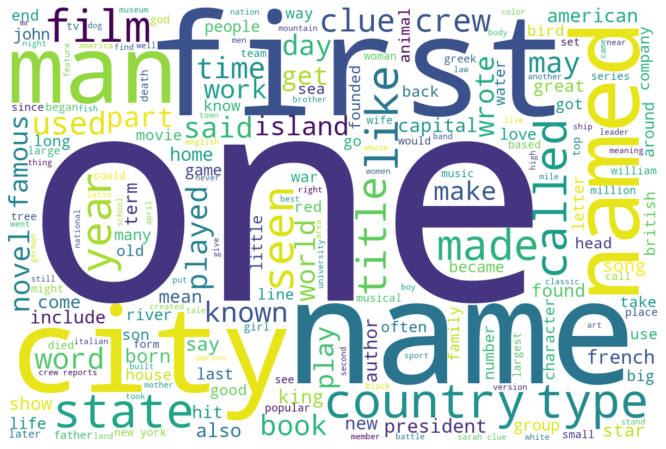

In [6]:
text = ""

for question in df.clean_question:
    text = text + question + " "
    
wordcloud = WordCloud(
    width=1200,
    height=800,
    stopwords=stopwords.words('english'),
    background_color='white'
).generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

The most common words from the `wordcloud` are non-contextual i.e. they can be used in any type of question irrespective of the context of the question. These results make it a compelling reason to look into bigrams or phrases to further analyse this point.

In [7]:
questions_overlap = []
phraze_used = set()
phraze_frequency = {}

def check_phraze(row):
    tokens = word_tokenize(row)
    split_question = [
        word for word in tokens if not word in stopwords.words('english')
    ]
    phrazes = list(bigrams(split_question))
    match_count = 0
    
    for phraze in phrazes:
        key = " ".join(phraze)
        if phraze in phraze_used:
            match_count += 1
            phraze_frequency[key] += 1
        else:
            phraze_frequency[key] = 1
        phraze_used.add(phraze)
        
    if len(split_question) > 1:
        questions_overlap.append(match_count/len(split_question))
        
df.clean_question.apply(check_phraze)
np.mean(questions_overlap)

0.1049441827579869

We see our findings to be completely different from what we achieved previously in terms of unigrams. As we cited before, single words may appear multiple times but not necessarily in the same context.

With bigrams, we partially considered (though not completely) meaning/context of some words appearing together in the questions. Just changing from unigrams to bigrams, there was a significant drop in the percentage of overlap in questions, about - 10.49% and even then, this is just a proxy/estimate and not the real story.

(-0.5, 1199.5, 799.5, -0.5)

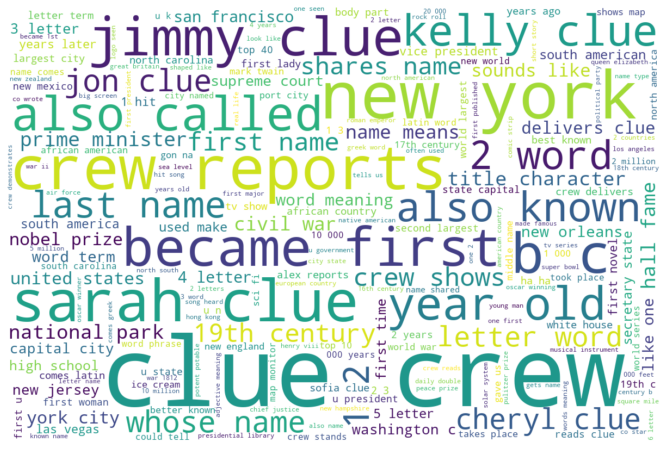

In [8]:
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white'
).generate_from_frequencies(phraze_frequency)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

Even though the bigrams gave a bit of context into the questions, we can see from the wordcloud that bigrams are still not a perfect representation of the context of the questions, and thus only show partially the repetition of questions on the show.

## High value questions and low value questions

In [9]:
df.value.describe()

count    19999.000000
mean       748.336267
std        653.988299
min          0.000000
25%        400.000000
50%        600.000000
75%       1000.000000
max      12000.000000
Name: value, dtype: float64

The mean is at 748.33. Rounding it to 750 looks like a good threshold.

In [10]:
df['value_level'] = df.value.apply(lambda x: 1 if x > 750 else 0)
df.head(5)

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer,answer_in_question,value_level
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was ...,copernicus,0.0,0
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisl...,jim thorpe,0.0,0
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,0.0,0
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show th...,mcdonald s,0.0,0
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the co...,john adams,0.0,0


Now we use the set terms_used function created earlier and observe the frequency of words for high and low value questions.

In [11]:
def observation(word):
    low_count = 0
    high_count = 0
    
    for i,row in df.iterrows():
        tokens = word_tokenize(row['clean_question'])
        if word in tokens:
            if row['value_level'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count,low_count

# apply the function for the first 5 words present in the set as a test
observed_values = []
vocab = pd.Series(list(terms_used)).sample(5,random_state=2)

for word in vocab:
    observed_values.append(observation(word))

vocab

4888         donuts
14436     zuiderzee
15808        dolley
14158    mindlessly
17682        sought
dtype: object

Now we write a function that calculates the expected values for these observed values. The logic behind it is straight forward. For each word, <br>

expected<sub>high</sub> = (high_count + low_count / total rows) * number of rows with high_value 1<br>
expected<sub>low</sub> = (high_count + low_count / total rows) * number of rows with high_value 0
<br>

Once we have these observed and expected values, for each word in our test set of 5 words, we perform a chi-square test to find the statistical significance.<br>

The null hypothesis is that there is no statistical significance between the two groups - high and low with respect to the word.<br>
The alternative hypothesis is that there exists some significance in the relationship of a word to the two groups - high and low<br>

What we are looking for is to understand if the words in the questions can lead us to identify whether the question is of high-value or low-value (>750 or <=750 dollars).

In [12]:
chi_squared = {}

def chi_test(observed_values,vocab):
    high_value_count = np.count_nonzero(df.value_level == 1)
    low_value_count = np.count_nonzero(df.value_level == 0)

    total_rows = len(df)

    for word,l in zip(vocab,observed_values):
        total = sum(l)
        total_prop = total / total_rows

        expected_high = total_prop * high_value_count
        expected_low = total_prop * low_value_count

        observed = np.array([l[0],l[1]])
        expected = np.array([expected_high,expected_low])

        chi_squared[word] = chisquare(observed,expected)
    
chi_test(observed_values,vocab)
chi_squared

{'donuts': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'zuiderzee': Power_divergenceResult(statistic=2.590084920817076, pvalue=0.10753457004402507),
 'dolley': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'mindlessly': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'sought': Power_divergenceResult(statistic=1.7665714689958703, pvalue=0.1838069565264469)}

For every word, the p-value is much higher than the threshold - 0.05. Hence, we fail to reject the null hypothesis. This means that by examining these 5 words, we found no statistical significance suggesting that these words can help us identify the type of question (high-value or low-value) we are dealing with. <br>

The above result is only for 5 terms, and maybe inconclusive of the bigger picture. so we now try it again with more words.

In [13]:
observed_values = []
vocab = pd.Series(list(terms_used)).sample(15,random_state=4)

for word in vocab:
    observed_values.append(observation(word))
print(observed_values)
vocab

[(1, 0), (1, 0), (1, 0), (3, 6), (0, 1), (0, 1), (0, 1), (1, 0), (1, 1), (1, 0), (7, 6), (1, 0), (1, 1), (1, 0), (2, 4)]


6291         obeying
14698      artichoke
9542         waspish
1525          barrel
8994       escamillo
7305        boroughs
4334        faxafloi
9794         logical
3359         calgary
2523     thingamajig
15104      steinbeck
5084        moseying
19429     definitive
1676        empfield
12073        kipling
dtype: object

In [14]:
chi_squared = {}
chi_test(observed_values,vocab)
chi_squared

{'obeying': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'artichoke': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'waspish': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'barrel': Power_divergenceResult(statistic=0.383744276979207, pvalue=0.5356061434563664),
 'escamillo': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'boroughs': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'faxafloi': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'logical': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'calgary': Power_divergenceResult(statistic=0.03360895727560264, pvalue=0.8545410902144307),
 'thingamajig': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'steinbeck': Power_divergenceResult(statistic=0.5581074545503374,

For these 15 terms, the results look pretty much the same and they don't seem to show any correlation that a word helps identifying the group (high-value or low-value) of the question.

## Rounds
Since checking value_level with words was a dead end, we now try to analyse a relationship that might be simpler: The rounds the game hosts. <br>

In [15]:
df['round'].value_counts()

Jeopardy!           9901
Double Jeopardy!    9762
Final Jeopardy!      335
Tiebreaker             1
Name: round, dtype: int64

In [16]:
cross_table = pd.crosstab(df['round'],df['value_level'])
cross_table

value_level,0,1
round,,
Double Jeopardy!,3507,6255
Final Jeopardy!,335,0
Jeopardy!,7442,2459
Tiebreaker,1,0


Looking at the data and the cross table with the value_level column, we can tell that the Double Jeopardy round holds the most high-value questions. But how do we know whether this phenomenon is just by chance (for this sample) or if this is true for the population? 

To check this, we now perform a chi-square test using the `scipy.stats.chi2_contingency` function on the cross table.<br>

The null hypothesis is that there is no correlation between the rounds and the value level of the questions.<br>
The alternative hypothesis is that there exists some correlation between the rounds and value level of the questions.

In [17]:
chi_sq,p_value,dof,expected = chi2_contingency(cross_table)
p_value

0.0

A p_value rounded to 0.0 means we can reject the null hypothesis, and can assume the alternate hypothesis to be true i.e. there exists a correlation between the rounds and value level of the questions.

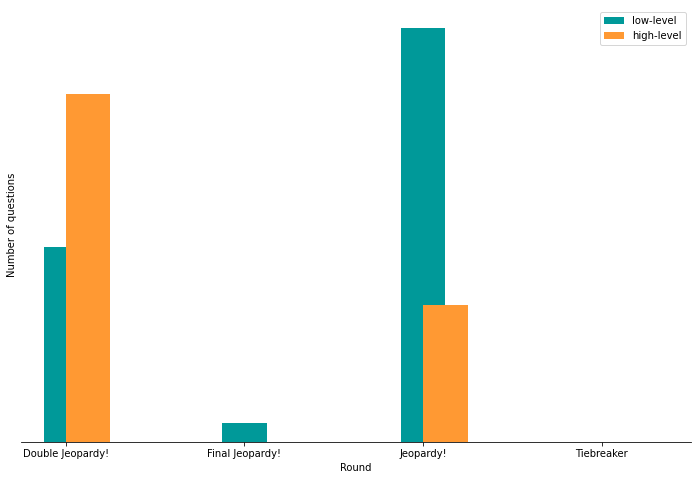

In [18]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Round')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking at the cross table and the plot, we can then conclude the direction of the differences. The first round 'Jeopardy' hosts more low-level questions whereas the second round 'Double Jeopardy' hosts more high-level questions. The final round 'Final Jeopardy' and the 'Tiebreaker' round host more low-level questions.

## Category
Now we look into the categories (topics) and the correlation with the value levels. By doing this we can have an idea of whether there exists a relationship/correlation between the value level and topic of the question.

In [19]:
df.category.value_counts()

TELEVISION                          51
U.S. GEOGRAPHY                      50
LITERATURE                          45
AMERICAN HISTORY                    40
BEFORE & AFTER                      40
                                    ..
1950s LITERATURE                     1
THE CAST OF THE TEN COMMANDMENTS     1
SHAKESPEAREAN TITLE CHARACTERS       1
RENAISSANCE LITERATURE               1
ALL GOD'S CREATURES                  1
Name: category, Length: 3581, dtype: int64

We follow a similar approach to finding the correlation between the words and value level of the questions. We first find the observed and expected frequencies of the high-value and low-value questions for each category, and then apply a chi-square test.<br>

The null hypothesis is that there is no correlation between the level of the value and the topic of the question.<br>
The alternative hypothesis is that there is a correlation between the level of the value and the topic of the question.<br>

We perform this analysis on the top 10 most frequent topics in the sample data.

In [20]:
catgs = df.category.value_counts().sort_values(ascending=False)[:10].index

def observed(catg):
    high_count = 0
    low_count = 0
    
    for i,row in df.iterrows():
        if row.category == catg:
            if row.value_level == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count,low_count

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
chi_squared = {}

def chi_test(observed_values,catgs):
    high_value_count = np.count_nonzero(df.value_level == 1)
    low_value_count = np.count_nonzero(df.value_level == 0)

    total_rows = len(df)

    for catg,l in zip(catgs,observed_values):
        total = sum(l)
        total_prop = total / total_rows

        expected_high = total_prop * high_value_count
        expected_low = total_prop * low_value_count

        observed = np.array([l[0],l[1]])
        expected = np.array([expected_high,expected_low])

        chi_squared[catg] = chisquare(observed,expected)
    
chi_test(observed_values,catgs)
chi_squared

{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405)}

Here we can see the majority of topics do not have a p_value <= 0.05, meaning for these topics we fail to reject the null hypothesis. However, for two topics - TELEVISION and BEFORE & AFTER, the null hypothesis is rejected and hence it can be said that there is a correlation with the value levels.<br> 

We have only performed these tests for the top 10 most frequent categories (topics) in the data. We now perform the same for the top 20 categories (topics).

In [21]:
catgs = df.category.value_counts().sort_values(ascending=False)[:20].index

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
print(catgs)

chi_squared = {}
chi_test(observed_values,catgs)
chi_squared

Index(['TELEVISION', 'U.S. GEOGRAPHY', 'LITERATURE', 'AMERICAN HISTORY',
       'BEFORE & AFTER', 'HISTORY', 'AUTHORS', 'WORD ORIGINS',
       'WORLD CAPITALS', 'BODIES OF WATER', 'SPORTS', 'SCIENCE & NATURE',
       'MAGAZINES', 'RHYME TIME', 'SCIENCE', 'WORLD GEOGRAPHY',
       'ANNUAL EVENTS', 'HISTORIC NAMES', 'WORLD HISTORY',
       'FICTIONAL CHARACTERS'],
      dtype='object')


{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405),
 'SPORTS': Po

We have new additions to our list of topics that have correlation with the value levels, they are - SPORTS, SCIENCE, SCIENCE & NATURE, IN THE DICTIONARY and the ones from the previous analysis as well - TELEVISION and BEFORE & AFTER.<br>

Now we make a cross table for these topics to understand the frequencies of these topics with respect to the value level.

In [22]:
catg_interest = [
    'SPORTS',
    'SCIENCE',
    'SCIENCE & NATURE',
    'IN THE DICTIONARY',
    'TELEVISION',
    'BEFORE & AFTER'
]

subset = df[df.category.isin(catg_interest)]
cross_table = pd.crosstab(subset.category,subset.value_level)
cross_table

value_level,0,1
category,,
BEFORE & AFTER,16,24
IN THE DICTIONARY,9,22
SCIENCE,14,21
SCIENCE & NATURE,14,21
SPORTS,29,7
TELEVISION,42,9


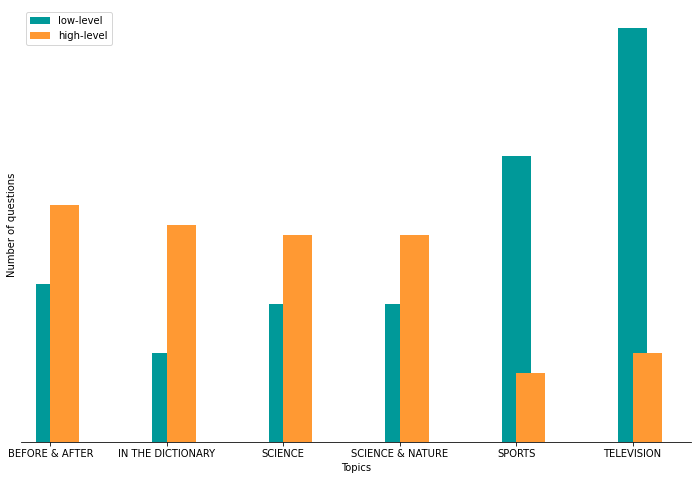

In [23]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Topics')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking at the cross table, the plot and the p_values obtained from before, we can say that the topics SPORTS and TELEVISION have a higher chance of being low-level questions, whereas the topics BEFORE & AFTER, IN THE DICTIONARY, SCIENCE, and SCIENCE & NATURE have a higher chance of being high-level questions.

## Conclusion
1. The answers are hardly hidden in the questions and hence the participant has to revise with all the categories (topics).    
2. The repetition of questions is rare, so the participant must not rely on reading previous questions to win the game.    
3. No relationship was found between the level of the question (>750 or <750 dollars) and the words present in the questions. Thus, the participant cannot estimate the level of the question with respect to the words in the question.
4. The first round, 'Jeopardy!' hosts mostly low-level (<750 dollars) questions. Whereas the second round 'Double Jeopardy!' hosts high-level (>750 dollars) questions. Participant's whose aim is to win more money can utilize these findings and play accordingly.
5. The categories (topics) - SPORTS and TELEVISION have a higher chance of having low-level (<750 dollars) questions, whereas the categories (topics) BEFORE & AFTER, IN THE DICTIONARY, SCIENCE, and SCIENCE & NATURE have a higher chance of having high-level (> 750 dollars) questions. 